In [ ]:
!pip install dask[complete]

In [ ]:
import pandas as pd
import dask.dataframe as dd
import time

def benchmark(df):
    start_time = time.time()
    result = (df['A'] ** 2 + df['B'] * 3 - df['C']).sum()
    execution_time = time.time() - start_time
    return result, execution_time

# Create a large sample dataframe with 3 columns
n = 10**7
data = {'A': range(n), 'B': range(n, 2 * n), 'C': range(2 * n, 3 * n)}
df_pandas = pd.DataFrame(data)

partitions_list = [1, 2, 4, 8, 16]
num_repeats = 5
results = {'Pandas': {}, 'Dask': {}}

for partitions in partitions_list:
    dask_partitioned = dd.from_pandas(df_pandas, npartitions=partitions)

    pandas_times = []
    dask_times = []

    for _ in range(num_repeats):
        # Shuffle the data
        df_pandas_shuffled = df_pandas.sample(frac=1)
        dask_partitioned_shuffled = dd.from_pandas(df_pandas_shuffled, npartitions=partitions)

        pandas_result, pandas_time = benchmark(df_pandas_shuffled)
        dask_result, dask_time = benchmark(dask_partitioned_shuffled)

        pandas_times.append(pandas_time)
        dask_times.append(dask_time)

    avg_pandas_time = sum(pandas_times) / num_repeats
    avg_dask_time = sum(dask_times) / num_repeats

    results['Pandas'][partitions] = avg_pandas_time
    results['Dask'][partitions] = avg_dask_time

for library, times in results.items():
    print(f"{library} Execution Times:")
    for partitions, avg_time in times.items():
        print(f"Partitions: {partitions} - Average Time: {avg_time:.6f} seconds")


Pandas Execution Times:
Partitions: 1 - Average Time: 0.147762 seconds
Partitions: 2 - Average Time: 0.129065 seconds
Partitions: 4 - Average Time: 0.128390 seconds
Partitions: 8 - Average Time: 0.130880 seconds
Partitions: 16 - Average Time: 0.131270 seconds
Dask Execution Times:
Partitions: 1 - Average Time: 0.006128 seconds
Partitions: 2 - Average Time: 0.005483 seconds
Partitions: 4 - Average Time: 0.005992 seconds
Partitions: 8 - Average Time: 0.005507 seconds
Partitions: 16 - Average Time: 0.005796 seconds


Pandas Execution Time:
Average Time: 0.001635 seconds

Best Dask Execution Time:
Average Time: 0.004239 seconds


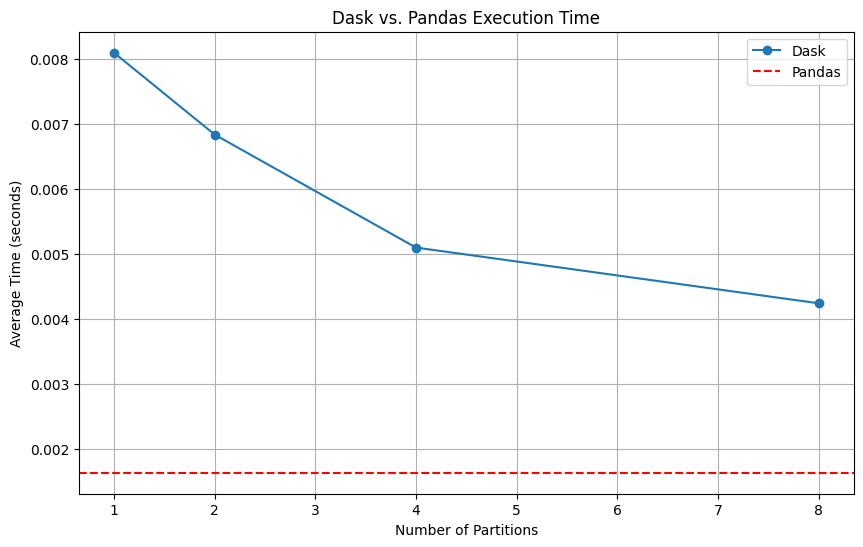

In [ ]:
import pandas as pd
import dask.dataframe as dd
import time
import matplotlib.pyplot as plt

def benchmark(df, num_repeats):
    times = []
    for _ in range(num_repeats):
        start_time = time.time()
        result = (df['A'] ** 2 + df['B'] * 3 - df['C']).sum()
        execution_time = time.time() - start_time
        times.append(execution_time)
    avg_time = sum(times) / num_repeats
    return result, avg_time

# Create a large/small sample dataframe with 3 columns
n = 10**5
data = {'A': range(n), 'B': range(n, 2 * n), 'C': range(2 * n, 3 * n)}
df_pandas = pd.DataFrame(data)

partitions_list = [1, 2, 4, 8]
num_repeats = 5
results = {'Pandas': 0, 'Dask': {}}

# Perform the Pandas benchmarking only once
pandas_result, avg_pandas_time = benchmark(df_pandas.sample(frac=1), num_repeats)
results['Pandas'] = avg_pandas_time

best_dask_time = float('inf')

for partitions in partitions_list:
    dask_partitioned_shuffled = dd.from_pandas(df_pandas.sample(frac=1), npartitions=partitions)

    dask_result, avg_dask_time = benchmark(dask_partitioned_shuffled, num_repeats)

    results['Dask'][partitions] = avg_dask_time
    best_dask_time = min(best_dask_time, avg_dask_time)

print("Pandas Execution Time:")
print(f"Average Time: {avg_pandas_time:.6f} seconds")

print("\nBest Dask Execution Time:")
print(f"Average Time: {best_dask_time:.6f} seconds")

# Plotting
partitions_list_for_plot = list(results['Dask'].keys())
dask_times_for_plot = list(results['Dask'].values())

plt.figure(figsize=(10, 6))
plt.plot(partitions_list_for_plot, dask_times_for_plot, marker='o', label='Dask')
plt.axhline(y=avg_pandas_time, color='r', linestyle='--', label='Pandas')
plt.xlabel('Number of Partitions')
plt.ylabel('Average Time (seconds)')
plt.title('Dask vs. Pandas Execution Time')
plt.legend()
plt.grid()
plt.show()


Finished benchmark for n = 1000
Finished benchmark for n = 10000
Finished benchmark for n = 100000
Finished benchmark for n = 1000000
Finished benchmark for n = 10000000


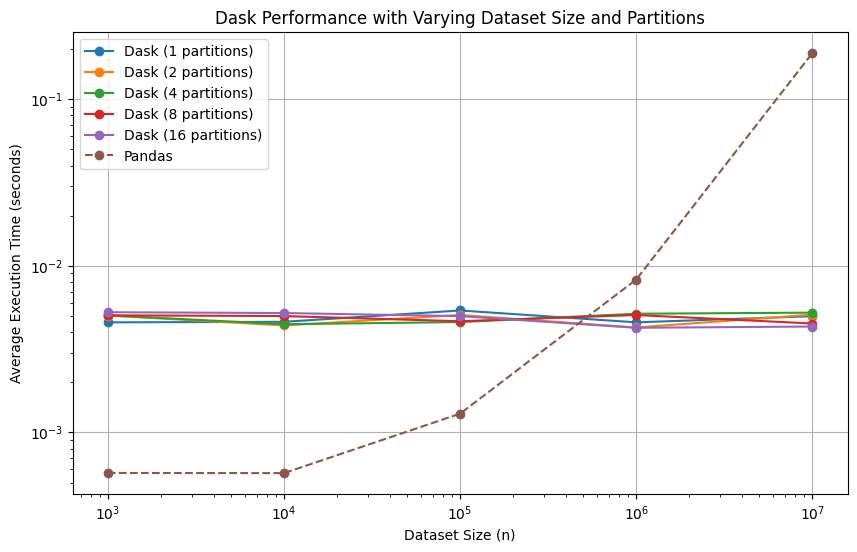

In [ ]:
import pandas as pd
import dask.dataframe as dd
import time
import matplotlib.pyplot as plt

def benchmark(df, num_repeats):
    times = []
    for _ in range(num_repeats):
        start_time = time.time()
        result = (df['A'] ** 2 + df['B'] * 3 - df['C']).sum()
        execution_time = time.time() - start_time
        times.append(execution_time)
    avg_time = sum(times) / num_repeats
    return result, avg_time

partitions_list = [1, 2, 4, 8, 16]
num_repeats = 5
results = {'Pandas': {}, 'Dask': {}}
data_length_range = [3,4,5,6,7]

for k in data_length_range:
    n = 10 ** k
    data = {'A': range(n), 'B': range(n, 2 * n), 'C': range(2 * n, 3 * n)}
    df_pandas = pd.DataFrame(data)

    pandas_result, avg_pandas_time = benchmark(df_pandas.sample(frac=1), num_repeats)
    results['Pandas'][n] = avg_pandas_time

    best_dask_time = float('inf')
    dask_partitioned_shuffled = dd.from_pandas(df_pandas.sample(frac=1), npartitions=1)  # Initialize with 1 partition

    for partitions in partitions_list:
        dask_partitioned_shuffled = dask_partitioned_shuffled.repartition(npartitions=partitions)

        dask_result, avg_dask_time = benchmark(dask_partitioned_shuffled, num_repeats)

        if n not in results['Dask']:
            results['Dask'][n] = {}
        results['Dask'][n][partitions] = avg_dask_time
        best_dask_time = min(best_dask_time, avg_dask_time)

    print(f"Finished benchmark for n = {n}")

# Plotting
plt.figure(figsize=(10, 6))

for partitions in partitions_list:
    dask_times = [results['Dask'][n][partitions] for n in results['Dask']]
    plt.plot(list(results['Dask']), dask_times, marker='o', label=f'Dask ({partitions} partitions)')

pandas_times = [results['Pandas'][n] for n in results['Pandas']]
plt.plot(list(results['Pandas']), pandas_times, marker='o', label='Pandas', linestyle='dashed')

plt.xlabel('Dataset Size (n)')
plt.ylabel('Average Execution Time (seconds)')
plt.xscale('log')
plt.yscale('log')
plt.title('Dask Performance with Varying Dataset Size and Partitions')
plt.legend()
plt.grid(True)
plt.show()
